In [1]:
import os
import gc
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

![](https://www.homecredit.ph/files/copy-hc-logo.png)

# DNN classifier in Tensorflow

This kernel will build a DNN classifier for the Home Credit Default Risk competition. The challenge here (as always!) is to try and match the performance of the LightGBM/XGBoost classifiers which always seems tricky for NNs for this kind of problem.

A lot of the feature engineering going into the model is from my previous kernel [here](https://www.kaggle.com/shep312/lightgbm-with-weighted-averages-dropout-771), so I will focus more on the NN graph development here.

### Contents

1. [Load and process data](#load)
    1. [Check nulls](#nulls)
    2. [Identify categoricals](#cats)
    3. [Scaling](#scale)
2. [Building the graph](#graph)
3. [Training the NN](#train)
4. [Analysis and submission](#submit)

## 1. Load and process data <a name="load"></a>

First step is to load all the different .csvs into memory.

In [2]:
input_dir = "../../../../../../Documents/TMP/Natural Computing/home-credit-default-risk/"
print('Input files:\n{}'.format(os.listdir(input_dir)))
print('Loading data sets...')

sample_size = None
app_train_df = pd.read_csv(os.path.join(input_dir, 'application_train.csv'), nrows=sample_size)
app_test_df = pd.read_csv(os.path.join(input_dir, 'application_test.csv'), nrows=sample_size)
bureau_df = pd.read_csv(os.path.join(input_dir, 'bureau.csv'), nrows=sample_size)
bureau_balance_df = pd.read_csv(os.path.join(input_dir, 'bureau_balance.csv'), nrows=sample_size)
credit_card_df = pd.read_csv(os.path.join(input_dir, 'credit_card_balance.csv'), nrows=sample_size)
pos_cash_df = pd.read_csv(os.path.join(input_dir, 'POS_CASH_balance.csv'), nrows=sample_size)
prev_app_df = pd.read_csv(os.path.join(input_dir, 'previous_application.csv'), nrows=sample_size)
install_df = pd.read_csv(os.path.join(input_dir, 'installments_payments.csv'), nrows=sample_size)
print('Data loaded.\nMain application training data set shape = {}'.format(app_train_df.shape))
print('Main application test data set shape = {}'.format(app_test_df.shape))
print('Positive target proportion = {:.2f}'.format(app_train_df['TARGET'].mean()))

Input files:
['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
Loading data sets...
Data loaded.
Main application training data set shape = (307511, 122)
Main application test data set shape = (48744, 121)
Positive target proportion = 0.08


In [3]:
app_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def feature_engineering(app_data, bureau_df, bureau_balance_df, credit_card_df,
                        pos_cash_df, prev_app_df, install_df):
    """ 
    Process the input dataframes into a single one containing all the features. Requires
    a lot of aggregating of the supplementary datasets such that they have an entry per
    customer.
    
    Also, add any new features created from the existing ones
    """
    
    # # Add new features
    
    # Amount loaned relative to salary
    app_data['LOAN_INCOME_RATIO'] = app_data['AMT_CREDIT'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY_INCOME_RATIO'] = app_data['AMT_ANNUITY'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY LENGTH'] = app_data['AMT_CREDIT'] / app_data['AMT_ANNUITY']
    
    # # Aggregate and merge supplementary datasets
    print('Combined train & test input shape before any merging  = {}'.format(app_data.shape))

    # Previous applications
    agg_funs = {'SK_ID_CURR': 'count', 'AMT_CREDIT': 'sum'}
    prev_apps = prev_app_df.groupby('SK_ID_CURR').agg(agg_funs)
    prev_apps.columns = ['PREV APP COUNT', 'TOTAL PREV LOAN AMT']
    merged_df = app_data.merge(prev_apps, left_on='SK_ID_CURR', right_index=True, how='left')

    # Average the rest of the previous app data
    prev_apps_avg = prev_app_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(prev_apps_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_PAVG'])
    print('Shape after merging with previous apps num data = {}'.format(merged_df.shape))
    
    # Previous app categorical features
    prev_app_df, cat_feats, _ = process_dataframe(prev_app_df)
    prev_apps_cat_avg = prev_app_df[cat_feats + ['SK_ID_CURR']].groupby('SK_ID_CURR')\
                             .agg({k: lambda x: str(x.mode().iloc[0]) for k in cat_feats})
    merged_df = merged_df.merge(prev_apps_cat_avg, left_on='SK_ID_CURR', right_index=True,
                            how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with previous apps cat data = {}'.format(merged_df.shape))

    # Credit card data - numerical features
    wm = lambda x: np.average(x, weights=-1/credit_card_df.loc[x.index, 'MONTHS_BALANCE'])
    credit_card_avgs = credit_card_df.groupby('SK_ID_CURR').agg(wm)   
    merged_df = merged_df.merge(credit_card_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CCAVG'])
    
    # Credit card data - categorical features
    most_recent_index = credit_card_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = credit_card_df.columns[credit_card_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(credit_card_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CCAVG'])
    print('Shape after merging with credit card data = {}'.format(merged_df.shape))

    # Credit bureau data - numerical features
    credit_bureau_avgs = bureau_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(credit_bureau_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with credit bureau data = {}'.format(merged_df.shape))
    
    # Bureau balance data
    most_recent_index = bureau_balance_df.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()
    bureau_balance_df = bureau_balance_df.loc[most_recent_index, :]
    merged_df = merged_df.merge(bureau_balance_df, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU',
                            how='left', suffixes=['', '_B_B'])
    print('Shape after merging with bureau balance data = {}'.format(merged_df.shape))

    # Pos cash data - weight values by recency when averaging
    wm = lambda x: np.average(x, weights=-1/pos_cash_df.loc[x.index, 'MONTHS_BALANCE'])
    f = {'CNT_INSTALMENT': wm, 'CNT_INSTALMENT_FUTURE': wm, 'SK_DPD': wm, 'SK_DPD_DEF':wm}
    cash_avg = pos_cash_df.groupby('SK_ID_CURR')['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE',
                                                 'SK_DPD', 'SK_DPD_DEF'].agg(f)
    merged_df = merged_df.merge(cash_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CAVG'])
    
    # Pos cash data data - categorical features
    most_recent_index = pos_cash_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = pos_cash_df.columns[pos_cash_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(pos_cash_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CAVG'])
    print('Shape after merging with pos cash data = {}'.format(merged_df.shape))

    # Installments data
    ins_avg = install_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(ins_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_IAVG'])
    print('Shape after merging with installments data = {}'.format(merged_df.shape))
    
    # Add more value counts
    merged_df = merged_df.merge(pd.DataFrame(bureau_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_BUREAU'])
    merged_df = merged_df.merge(pd.DataFrame(credit_card_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_CRED_CARD'])
    merged_df = merged_df.merge(pd.DataFrame(pos_cash_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_POS_CASH'])
    merged_df = merged_df.merge(pd.DataFrame(install_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_INSTALL'])
    print('Shape after merging with counts data = {}'.format(merged_df.shape))

    return merged_df

In [5]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """

    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    categorical_feats = categorical_feats
    encoder_dict = {}
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
        encoder_dict[feat] = encoder

    return input_df, categorical_feats.tolist(), encoder_dict

Since they are in disparate .csv's next I need to merge them into a single use-able dataframe:

In [6]:
# Merge the datasets into a single one for training
len_train = len(app_train_df)
app_both = pd.concat([app_train_df, app_test_df])
#merged_df = feature_engineering(app_both, bureau_df, bureau_balance_df, credit_card_df, pos_cash_df, prev_app_df, install_df)
#merged_df.to_csv("merged_df.csv", index=False)
merged_df = pd.read_csv("merged_df.csv")
# Separate metadata
meta_cols = ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']
meta_df = merged_df[meta_cols]
merged_df.drop(meta_cols, axis=1, inplace=True)

# Process the data set.
merged_df, categorical_feats, encoder_dict = process_dataframe(input_df=merged_df)

C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Capture other categorical features not as object data types:
non_obj_categoricals = [
    'FONDKAPREMONT_MODE',
    'HOUR_APPR_PROCESS_START',
    'HOUSETYPE_MODE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 
    'NAME_TYPE_SUITE', 
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 
    'WALLSMATERIAL_MODE',
    'WEEKDAY_APPR_PROCESS_START', 
    'NAME_CONTRACT_TYPE_BAVG',
    'WEEKDAY_APPR_PROCESS_START_BAVG',
    'NAME_CASH_LOAN_PURPOSE', 
    'NAME_CONTRACT_STATUS', 
    'NAME_PAYMENT_TYPE',
    'CODE_REJECT_REASON', 
    'NAME_TYPE_SUITE_BAVG', 
    'NAME_CLIENT_TYPE',
    'NAME_GOODS_CATEGORY', 
    'NAME_PORTFOLIO', 
    'NAME_PRODUCT_TYPE',
    'CHANNEL_TYPE', 
    'NAME_SELLER_INDUSTRY', 
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION', 
    'NAME_CONTRACT_STATUS_CCAVG', 
    'STATUS',
    'NAME_CONTRACT_STATUS_CAVG'
]
categorical_feats = categorical_feats + non_obj_categoricals

Before I do any futher processing, extract the target variable for training later.

In [8]:
# Extract target before scaling
labels = merged_df.pop('TARGET')
labels = labels[:len_train]

# Reshape (one-hot)
target = np.zeros([len(labels), len(np.unique(labels))])
target[:, 0] = labels == 0
target[:, 1] = labels == 1


### 1.1 Check nulls <a name="nulls"></a>

The data set has a a few variables containing a lot of nulls. Drop any features that are over x% null, then fill with 0. This obviously isn't a great method and provides room for improvement later on.

In [9]:
null_counts = merged_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_ratios = null_counts / len(merged_df)

# Drop columns over x% null
null_thresh = .8
null_cols = null_ratios[null_ratios > null_thresh].index
merged_df.drop(null_cols, axis=1, inplace=True)
print('Columns dropped for being over {}% null:'.format(100*null_thresh))
for col in null_cols:
    print(col)
    if col in categorical_feats:
        categorical_feats.pop(col)
    
# Fill the rest with the mean (TODO: do something better!)
# merged_df.fillna(merged_df.median(), inplace=True)
merged_df.fillna(0, inplace=True)

Columns dropped for being over 80.0% null:
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY
AMT_PAYMENT_CURRENT
CNT_DRAWINGS_ATM_CURRENT
CNT_DRAWINGS_OTHER_CURRENT
CNT_DRAWINGS_POS_CURRENT
CNT_INSTALMENT_MATURE_CUM
MONTHS_BALANCE_B_B


### 1.2 Identify categorical variables <a name="cats"></a>

Categorical variables will be important in this model - there are a lot of them and a few that have high cardinality. 

I will be creating embeddings to encode them for use in the model later, but for now just make a note of them and their positions.

In [10]:
cat_feats_idx = np.array([merged_df.columns.get_loc(x) for x in categorical_feats])
int_feats_idx = [merged_df.columns.get_loc(x) for x in non_obj_categoricals]
cat_feat_lookup = pd.DataFrame({'feature': categorical_feats, 'column_index': cat_feats_idx})
cat_feat_lookup.head()

,feature,column_index
0,CODE_GENDER,18
1,EMERGENCYSTATE_MODE,32
2,FLAG_OWN_CAR,63
3,FLAG_OWN_REALTY,64
4,FONDKAPREMONT_MODE,73


In [11]:
cont_feats_idx = np.array(
    [merged_df.columns.get_loc(x) 
     for x in merged_df.columns[~merged_df.columns.isin(categorical_feats)]]
)
cont_feat_lookup = pd.DataFrame(
    {'feature': merged_df.columns[~merged_df.columns.isin(categorical_feats)], 
     'column_index': cont_feats_idx}
)
cont_feat_lookup.head()

,feature,column_index
0,AMT_ANNUITY,0
1,AMT_CREDIT,1
2,AMT_GOODS_PRICE,2
3,AMT_INCOME_TOTAL,3
4,AMT_REQ_CREDIT_BUREAU_DAY,4


### 1.3 Scaling <a name="scale"></a>

Next data processing step is to scale the features so they don't get unfairly weighted against each other.

In [12]:
scaler = StandardScaler()
final_col_names = merged_df.columns
merged_df = merged_df.values
merged_df[:, cont_feats_idx] = scaler.fit_transform(merged_df[:, cont_feats_idx])

scaler_2 = MinMaxScaler(feature_range=(0, 1))
merged_df[:, int_feats_idx] = scaler_2.fit_transform(merged_df[:, int_feats_idx])

## 2. Building the graph <a name="graph"></a>

Now the data is in decent shape, build the NN. 

First step, however, is to re-separate the competition train and test sets. I'll then further split the training set down to provide a hold out validation set.

In [13]:
# Re-separate into labelled and unlabelled
train_df = merged_df[:len_train]
predict_df = merged_df[len_train:]
del merged_df, app_train_df, app_test_df, bureau_df, bureau_balance_df, credit_card_df, pos_cash_df, prev_app_df
gc.collect()

# Create a validation set to check training performance
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, test_size=0.1, random_state=2, stratify=target[:, 0])

Set the parameters for the network:

In [14]:
# Fixed graph parameters
# EMBEDDING_SIZE = 3  # Use cardinality / 2 instead
N_HIDDEN_1 = 80
N_HIDDEN_2 = 80
N_HIDDEN_3 = 40
n_cont_inputs = X_train[:, cont_feats_idx].shape[1]
n_classes = 2

# Learning parameters
LEARNING_RATE = 0.01
N_EPOCHS = 30
N_ITERATIONS = 400
BATCH_SIZE = 250
#max_early_stop = 10
N_E = [1,10,50,100]
early_stopping_epochs = 2

print('Number of continous features: ', n_cont_inputs)
print('Number of categoricals pre-embedding: ', X_train[:, cat_feats_idx].shape[1])

Number of continous features:  165
Number of categoricals pre-embedding:  49


Graph itself. Note that there is an embedding step first where each categorical feature is embedded and attached to the continuous input features.

In [15]:
def embed_and_attach(X, X_cat, cardinality):  
    embedding = tf.Variable(tf.random_uniform([cardinality, cardinality // 2], -1.0, 1.0))
    embedded_x = tf.nn.embedding_lookup(embedding, X_cat) 
    return tf.concat([embedded_x, X], axis=1)

In [16]:
# # Graph
tf.reset_default_graph()

# Define placeholders for the categorical varaibles
cat_placeholders, cat_cardinalities = [], []
for idx in cat_feats_idx:
    exec('X_cat_{} = tf.placeholder(tf.int32, shape=(None, ), name=\'X_cat_{}\')'.format(idx, idx))
    exec('cat_placeholders.append(X_cat_{})'.format(idx))
    cat_cardinalities.append(len(np.unique(np.concatenate([train_df[:, idx], 
                                                           predict_df[:, idx]], axis=0))))
    
# Other placeholders
X_cont = tf.placeholder(tf.float32, shape=(None, n_cont_inputs), name='X_cont')
y = tf.placeholder(tf.int32, shape=(None,n_classes), name='labels')
train_mode = tf.placeholder(tf.bool)

# Add embeddings to input
X = tf.identity(X_cont)
for feat, card in zip(cat_placeholders, cat_cardinalities):
    X = embed_and_attach(X, feat, card)

# Define the network layers. 
# Overfitting is a challenge so add L2 regularisation to weights in 1st layer & 
# a couple of dropout layers
with tf.name_scope('dnn'):
    hidden_layer_1 = tf.layers.dense(inputs=X,
                                     units=N_HIDDEN_1,
                                     name='first_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.3))
    hidden_layer_1 = tf.layers.batch_normalization(hidden_layer_1, training=train_mode)
    hidden_layer_1 = tf.nn.relu(hidden_layer_1)
    
    drop_layer_1 = tf.layers.dropout(inputs=hidden_layer_1, 
                                     rate=0.4, 
                                     name='first_dropout_layer',
                                     training=train_mode)

    hidden_layer_2 = tf.layers.dense(inputs=drop_layer_1,
                                     units=N_HIDDEN_2,
                                     name='second_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    hidden_layer_2 = tf.layers.batch_normalization(hidden_layer_2, training=train_mode)
    hidden_layer_2 = tf.nn.relu(hidden_layer_2)
                                     
    drop_layer_2 = tf.layers.dropout(inputs=hidden_layer_2, 
                                     rate=0.2, 
                                     name='second_dropout_layer',
                                     training=train_mode)

    hidden_layer_3 = tf.layers.dense(inputs=drop_layer_2,
                                     units=N_HIDDEN_3,
                                     name='third_hidden_layer')
    hidden_layer_3 = tf.layers.batch_normalization(hidden_layer_3, training=train_mode)
    hidden_layer_3 = tf.nn.relu(hidden_layer_3)

    logits = tf.layers.dense(inputs=hidden_layer_3,
                             units=n_classes,
                             name='outputs')

# Define the loss function for training as cross entropy
with tf.name_scope('loss'):
    xent = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    loss = tf.reduce_mean(xent, name='loss')

# Define the optimiser
with tf.name_scope('train'):
    optimiser = tf.train.AdamOptimizer()  # AdagradOptimizer(learning_rate=LEARNING_RATE)
    train_step = optimiser.minimize(loss)

# Output the class probabilities to I can get the AUC
with tf.name_scope('eval'):
    predict = tf.argmax(logits, axis=1, name='class_predictions')
    predict_proba = tf.nn.softmax(logits, name='probability_predictions')

# Initialisation node and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dropout instead.


## 3. Training the NN <a name="train"></a>

Time to train the network. We know that only 8% of the targets are positive, so I will be upsampling positives for the gradient descent batches. I'm going to go with even representation in the training batches, but this isn't necessarily going to get the best score so may need optimising.

In [17]:
def get_feed_dict(cat_feats_idx, cat_placeholders, cont_feats_idx, batch_X, batch_y=None,
                 training=False):
    """ Return a feed dict for the graph including all the categorical features
    to embed """
    
    # Continuous X features and the labels if training run
    feed_dict = {X_cont: batch_X[:, cont_feats_idx]}
    if batch_y is not None:
        feed_dict[y] = batch_y
        
    # Loop through the categorical features to provide values for the placeholders
    for idx, tensor in zip(cat_feats_idx, cat_placeholders):
        feed_dict[tensor] = batch_X[:, idx].reshape(-1, ).astype(int)
        
    # Training mode or not
    feed_dict[train_mode] = training
        
    return feed_dict

In [18]:
from tqdm.notebook import trange, tqdm
import math

i = 0 

indices = list(range(X_train.shape[0]))
X_train_o = X_train
y_train_o = y_train
result_dict = {}

for loop in trange(len(N_E), desc= "Training"):
    
        #bagging 
       # print('Training for {} iterations over {} epochs with batchsize {} for {} estimator(s) ...'
          #        .format(N_ITERATIONS, N_EPOCHS, BATCH_SIZE,N_E[loop]))
    early = 0
    y_final_prob_train = []
    y_final_prob_val = []
    y_final_prob_test = []
    final_train_auc, final_valid_auc = [], []
    for estimator in tqdm(range(N_E[loop]), desc= "Training {} estimators".format(N_E[loop]), leave=False):
        # start with a clean session for each estimator
        with tf.Session() as sess:
            train_auc, valid_auc = [], []
            n_rounds_not_improved = 0
            #bootstrap
            train_indices  = resample(indices, replace=True, random_state=(loop*estimator))
            X_train = X_train_o[train_indices]
            y_train = y_train_o[train_indices]
            init.run()

            # Begin epoch loop
            earlystop = False
            for epoch in tqdm(range(N_EPOCHS),desc="Epoch", leave=False):
                if earlystop == False:

                    # Iteration loop
                    for iteration in tqdm(range(N_ITERATIONS),desc="Itteration", leave=False):

                        # Get random selection of data for batch GD. Upsample positive classes to make it
                        # balanced in the training batch
                        pos_ratio = 0.5
                        pos_idx = np.random.choice(np.where(y_train[:, 1] == 1)[0], 
                                                   size=int(np.round(BATCH_SIZE*pos_ratio)))
                        neg_idx = np.random.choice(np.where(y_train[:, 1] == 0)[0], 
                                                   size=int(np.round(BATCH_SIZE*(1-pos_ratio))))
                        idx = np.concatenate([pos_idx, neg_idx])

                        # Run training
                        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                        sess.run([train_step, extra_update_ops], 
                                 feed_dict=get_feed_dict(cat_feats_idx, cat_placeholders, cont_feats_idx, 
                                                         X_train[idx, :], y_train[idx, :], 1))

                    # Check on the AUC
                    y_pred_train, y_prob_train = sess.run(
                        [predict, predict_proba], feed_dict=get_feed_dict(
                            cat_feats_idx, cat_placeholders, cont_feats_idx, X_train, y_train, False))
                    train_auc.append(roc_auc_score(y_train[:, 1], y_prob_train[:, 1]))

                    y_pred_val, y_prob_val = sess.run(
                        [predict, predict_proba], feed_dict=get_feed_dict(
                            cat_feats_idx, cat_placeholders, cont_feats_idx, X_valid, y_valid, False))
                    valid_auc.append(roc_auc_score(y_valid[:, 1], y_prob_val[:, 1]))

                    # Early stopping after AUC doesn't improve within epochs
                    if epoch > 1:
                        best_epoch_so_far = np.argmax(valid_auc[:-1])
                        if valid_auc[epoch] <= valid_auc[best_epoch_so_far]:
                            n_rounds_not_improved += 1
                        else:
                            n_rounds_not_improved = 0
                        if (n_rounds_not_improved > early_stopping_epochs):
                            earlystop = True
                # repeat best value if early stopped
                else: 
                    train_auc.append(train_auc[best_epoch_so_far])
                    valid_auc.append(valid_auc[best_epoch_so_far])
            """
                        early = 0
                    if (n_rounds_not_improved > early_stopping_epochs) and not stale:
                        early += 1
                        stale = True
            if early == max_early_stop:
                print('Early stopping loop {} due to early stopping of {} estimators.'
                              .format(loop+1, early))
                break
            """
            # Check on the AUC
            y_pred_train, y_prob_train = sess.run(
                [predict, predict_proba], feed_dict=get_feed_dict(
                    cat_feats_idx, cat_placeholders, cont_feats_idx, X_train, y_train, False))
            

            y_pred_val, y_prob_val = sess.run(
                [predict, predict_proba], feed_dict=get_feed_dict(
                    cat_feats_idx, cat_placeholders, cont_feats_idx, X_valid, y_valid, False))
           
            y_prob_test = sess.run(predict_proba, feed_dict=get_feed_dict(
                cat_feats_idx, cat_placeholders, cont_feats_idx, predict_df, None, False))
            
            if estimator == 0:
                y_final_prob_train = y_prob_train
                y_final_prob_val = y_prob_val
                y_final_prob_test = y_prob_test
                final_train_auc, final_valid_auc = np.array(train_auc), np.array(valid_auc)
                
            else:
                y_final_prob_train = np.array(y_prob_train) + np.array(y_final_prob_train)
                y_final_prob_val = np.array(y_prob_val) + np.array(y_final_prob_val)
                y_final_prob_test = np.array(y_prob_test) + np.array(y_final_prob_test)
                final_train_auc = np.array(final_train_auc) + np.array(train_auc)
                final_valid_auc = np.array(final_valid_auc) + np.array(valid_auc)
            del sess
            gc.collect
    y_final_prob_train = y_final_prob_train/  (estimator +1)
    y_final_prob_val = y_final_prob_val/  (estimator +1)
    y_final_prob_test = y_final_prob_test/  (estimator +1)
    final_train_auc = final_train_auc/ (estimator +1)
    final_valid_auc = final_valid_auc / (estimator +1)
    y_final_pred_train = np.argmax(y_final_prob_train, axis=1)
    y_final_pred_val = np.argmax(y_final_prob_val, axis=1)
    y_final_pred_test = np.argmax(y_final_prob_test, axis=1)

    result_dict[N_E[loop]]= [y_final_prob_train,y_final_prob_val,y_final_prob_test,
                             y_final_pred_train,y_final_pred_val,y_final_pred_test,
                            final_train_auc, final_valid_auc]
    print('estimators = {}, Train AUC = {:.8f}, Valid AUC = {:.8f}'
          .format(N_E[loop], train_auc[epoch], valid_auc[epoch]))
    # Once trained, make predictions
    print('Training complete.')
        
        

estimators = 1, Train AUC = 0.78719563, Valid AUC = 0.74754580
Training complete.


estimators = 10, Train AUC = 0.80081071, Valid AUC = 0.75005817
Training complete.


estimators = 50, Train AUC = 0.80701480, Valid AUC = 0.75277259
Training complete.


estimators = 100, Train AUC = 0.79065141, Valid AUC = 0.75059920
Training complete.



# result_dict
[0] y_final_prob_train,

[1] y_final_prob_val,

[2] y_final_prob_test,

[3] y_final_pred_train,

[4] y_final_pred_val,

[5] y_final_pred_test,

[6] final_train_auc, 

[7] final_valid_auc

So an OK performance, but not matching the gradient boosted results yet. There's a lot of avenues to improve, however, including but not limited to:

- **Optimising number of nodes / width**: Currently I've only used a small number of nodes in the hidden layers, limiting the complexity of the model. More nodes should lead to better performance, but I found that it started to overfit. There is probably a way to regularise the network to allow it to get more complex
- **Number of layers**: Currently at 3 hidden layers deep, could be a better number
- **Upsampling of positives**: Reduction in the upsampling of postive samples could be tuned
- **Other hyperparameters**: Learning rate, batch size etc. could be tuned

## 4. Analysis and Submission <a name="submit"></a>

Lets have a look at some summarising plots, then submit the results. 

Training curves & the ROC curve:

In [25]:
def plot_per_roc(results, y_valid):
    R_C = ["red","blue", "green","orange", "pink"]
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])
    i = 0
    for key in results.keys():
        res = results[key]
        ax.plot(np.arange(len(res[6])), res[6], label='{} estimator(s)'.format(key), c = R_C[i] )
        ax.plot(np.arange(len(res[7])), res[7], linestyle='--', c = R_C[i])
        i += 1
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.set_title('Training performance')
    i = 0
    for key in results.keys():
        res = results[key]
        fpr, tpr, _ = roc_curve(y_valid[:, 1], res[1][:, 1])
        ax1.plot(fpr, tpr, label='ROC curve {} estimator(s) (area = {:.2f})'.format(key,res[7][epoch]), c = R_C[i])
        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', c="black")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')

    for a in [ax, ax1]:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.legend(frameon=False, loc="lower right")

    plt.show()

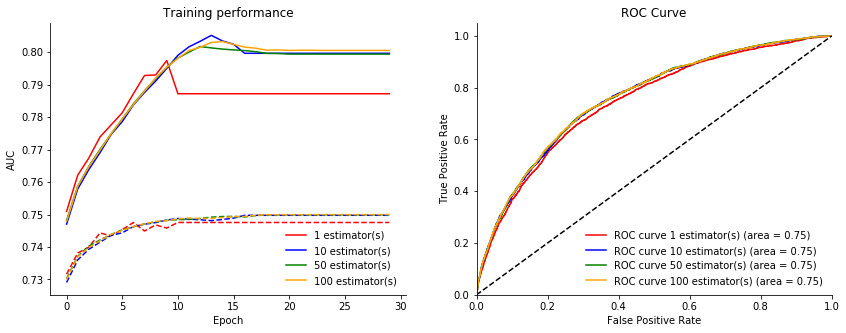

In [26]:
plot_per_roc(result_dict,y_valid)

...and a precision-recall curve and the confusion matrix:

In [27]:
def plot_pre_rec(y_valid, y_prob_val, y_pred_val,estimators): 
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])
    print("{} estimators".format(estimators))
    # Precision recall curve
    precision, recall, _ = precision_recall_curve(y_valid[:, 1], y_prob_val[:, 1])
    acc = accuracy_score(y_valid[:, 1], y_pred_val)
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('Precision - recall curve')

    # Confusion matrix
    cnf_matrix = confusion_matrix(y_valid[:, 1], np.argmax(y_prob_val, axis=1))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    heatmap = sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax1, cmap=cmap, center=0)
    ax1.set_title('Confusion matrix heatmap ({}% accuracy)'.format(round(acc,2)))
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    plt.show()

1 estimators


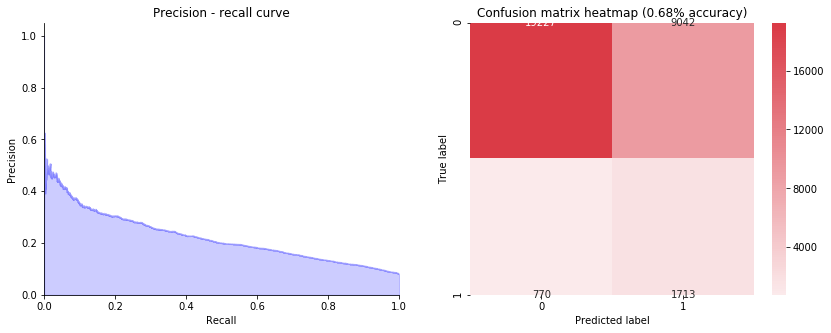

10 estimators


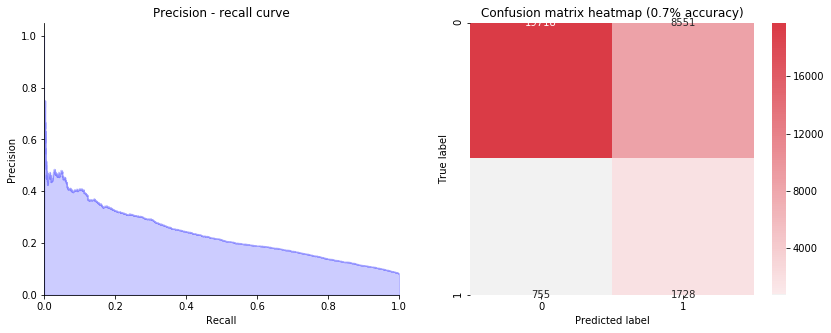

50 estimators


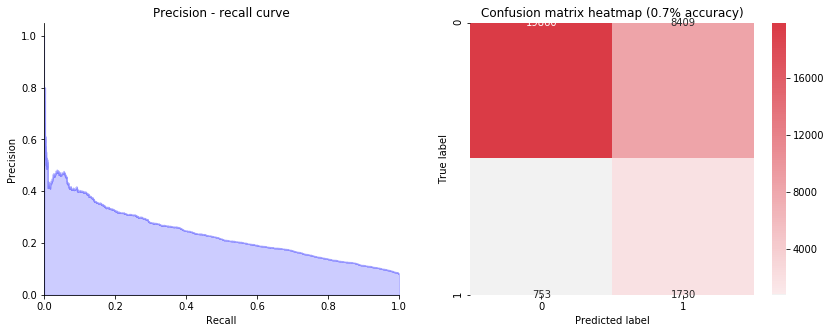

100 estimators


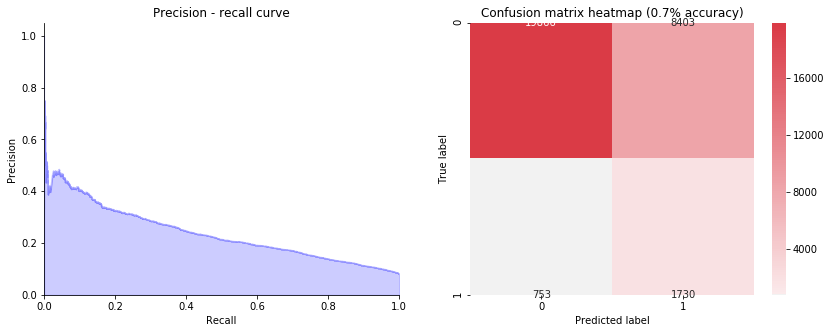

In [28]:
for key in result_dict.keys():
        res = result_dict[key]
        plot_pre_rec(y_valid, res[1], res[4], key)
        out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': res[2][:, 1]})
        out_df.to_csv('{}_nn_submission.csv'.format(key), index=False)

In [23]:
from sklearn.metrics import recall_score, precision_score, f1_score
EstimatorDF = pd.DataFrame(columns=['n_estimators', 'accuracy_score', 'F1 micro', 'F1 macro', 'precision macro', 'precision micro', 'recall macro','recall micro'])
for estimators in result_dict.keys():
    y_true = y_valid[:, 1]
    y_pred = result_dict[estimators][4]
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_micro = precision_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    new_row = {'n_estimators' : estimators, 'accuracy_score': accuracy, 'F1 micro' : f1_micro,'F1 macro' : f1_macro,
               'precision macro':precision_macro, 'precision micro':precision_micro,
               'recall macro':recall_macro,'recall micro':recall_micro}
    #append row to the dataframe
    EstimatorDF = EstimatorDF.append(new_row, ignore_index=True)
EstimatorDF["n_estimators"] = EstimatorDF["n_estimators"].astype('int32')
print(EstimatorDF)

   n_estimators  accuracy_score  F1 micro  F1 macro  precision macro  \
0             1        0.680931  0.680931  0.527755         0.560384   
1            10        0.697386  0.697386  0.539940         0.565616   
2            50        0.702068  0.702068  0.543347         0.567049   
3           100        0.702263  0.702263  0.543485         0.567105   

   precision micro  recall macro  recall micro  
0         0.680931      0.685018      0.680931  
1         0.697386      0.696723      0.697386  
2         0.702068      0.699637      0.702068  
3         0.702263      0.699743      0.702263  


In [24]:
EstimatorDF.to_csv('Credit.csv', index=False)